In [114]:
import numpy as np
import pandas as pd
import os

# 1.数据概览

In [115]:
df=pd.read_excel('Downloads/Document/PYTHON-RFM实战数据.xlsx')
df.head()

,品牌名称,买家昵称,付款日期,订单状态,实付金额,邮费,省份,城市,购买数量
0,数据不吹牛,叫我李2,2019-01-01 00:17:59,交易成功,186,6,上海,上海市,1
1,数据不吹牛,0cyb1992,2019-01-01 00:59:54,交易成功,145,0,广东省,广州市,1
2,数据不吹牛,萝污萌莉,2019-01-01 07:48:48,交易成功,194,8,山东省,东营市,1
3,数据不吹牛,atblovemyy,2019-01-01 09:15:49,付款以后用户退款成功，交易自动关闭,84,0,江苏省,镇江市,1
4,数据不吹牛,小星期鱼,2019-01-01 09:59:33,付款以后用户退款成功，交易自动关闭,74,0,上海,上海市,1


In [116]:
df['订单状态'].unique()

array(['交易成功', '付款以后用户退款成功，交易自动关闭'], dtype=object)

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28833 entries, 0 to 28832
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   品牌名称    28833 non-null  object        
 1   买家昵称    28833 non-null  object        
 2   付款日期    28833 non-null  datetime64[ns]
 3   订单状态    28833 non-null  object        
 4   实付金额    28833 non-null  int64         
 5   邮费      28833 non-null  int64         
 6   省份      28833 non-null  object        
 7   城市      28832 non-null  object        
 8   购买数量    28833 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 2.0+ MB


# 2.数据清洗

In [118]:
#删除退款
df=df.loc[df['订单状态']=='交易成功',:]
print('剔除退款后还剩：%d行'%len(df))

剔除退款后还剩：27793行


In [119]:
# 关键字段提取
df=df[['买家昵称','付款日期','实付金额']]
df.head()

,买家昵称,付款日期,实付金额
0,叫我李2,2019-01-01 00:17:59,186
1,0cyb1992,2019-01-01 00:59:54,145
2,萝污萌莉,2019-01-01 07:48:48,194
5,重碎叠,2019-01-01 10:00:07,197
6,iho_jann,2019-01-01 10:00:08,168


R值的构造（最近一次购买距今多少天)

如果用户只下单过一次，用现在的日期减去付款日期即可；若是用户多次下单，需先筛选出这个用户最后一次付款的时间，再用今天减去它。
就是距离今天越近，时间也就越“大”
按买家昵称分组，再选取付款日期的最大值

In [120]:
r=df.groupby('买家昵称')['付款日期'].max().reset_index()
r.head()

,买家昵称,付款日期
0,.blue_ram,2019-02-04 17:49:34.000
1,.christiny,2019-01-29 14:17:15.000
2,.willn1,2019-01-11 03:46:18.000
3,.托托m,2019-01-11 02:26:33.000
4,0000妮,2019-06-28 16:53:26.458


In [121]:
r['R']=(pd.to_datetime('2019-7-1')-r['付款日期']).dt.days
r=r[['买家昵称','R']]
r.head()

,买家昵称,R
0,.blue_ram,146
1,.christiny,152
2,.willn1,170
3,.托托m,170
4,0000妮,2


F值的构造（用户购买频次）

原则：以天为单位，即用户一天内多次下单算一次
引入一个精确到天的日期标签，依照“买家昵称”和“日期标签”进行分组，把每个用户一天内的多次下单行为合并，再统计购买次数

In [122]:
df['日期标签']=df['付款日期'].astype(str).str[:10]
df.head()

,买家昵称,付款日期,实付金额,日期标签
0,叫我李2,2019-01-01 00:17:59,186,2019-01-01
1,0cyb1992,2019-01-01 00:59:54,145,2019-01-01
2,萝污萌莉,2019-01-01 07:48:48,194,2019-01-01
5,重碎叠,2019-01-01 10:00:07,197,2019-01-01
6,iho_jann,2019-01-01 10:00:08,168,2019-01-01


In [123]:
df_f=df.groupby(['买家昵称','日期标签']).count().reset_index()
df_f.head()

,买家昵称,日期标签,付款日期,实付金额
0,.blue_ram,2019-02-04,1,1
1,.christiny,2019-01-29,1,1
2,.willn1,2019-01-11,1,1
3,.托托m,2019-01-11,1,1
4,0000妮,2019-06-28,1,1


In [124]:
f=df_f.groupby('买家昵称')['日期标签'].count().reset_index()
f.columns=['买家昵称','F']
f.head()

,买家昵称,F
0,.blue_ram,1
1,.christiny,1
2,.willn1,1
3,.托托m,1
4,0000妮,1


M值构造（用户平均支付金额）

In [125]:
df_m=df.groupby('买家昵称')['实付金额'].sum().reset_index()
df_m.head()

,买家昵称,实付金额
0,.blue_ram,49
1,.christiny,183
2,.willn1,34
3,.托托m,37
4,0000妮,164


In [126]:
mf=pd.merge(df_m,f,left_on='买家昵称',right_on='买家昵称',how='inner')
mf.head()

,买家昵称,实付金额,F
0,.blue_ram,49,1
1,.christiny,183,1
2,.willn1,34,1
3,.托托m,37,1
4,0000妮,164,1


In [127]:
mf['M']=mf['实付金额']/mf['F']
mf.head()

,买家昵称,实付金额,F,M
0,.blue_ram,49,1,49.0
1,.christiny,183,1,183.0
2,.willn1,34,1,34.0
3,.托托m,37,1,37.0
4,0000妮,164,1,164.0


In [128]:
rmf=pd.merge(mf,r,left_on='买家昵称',right_on='买家昵称',how='inner')
rmf.head()

,买家昵称,实付金额,F,M,R
0,.blue_ram,49,1,49.0,146
1,.christiny,183,1,183.0,152
2,.willn1,34,1,34.0,170
3,.托托m,37,1,37.0,170
4,0000妮,164,1,164.0,2


# 3.维度打分

核心：越喜欢的行为，分值越高

R值越大，用户流失几率越高，分值越小
F值越大，用户购买频次越高，分值越大
M值越大，用户平均购买金额越大，分值越高

分值按照数据分位数划分

R值根据行业经验，设置为30天一个跨度，区间左闭右开：

|  R值打分 |  R值 |  含义 |
| :------------: | :------------: | :------------: |
| 1  | [120,&infin;)  |  120天以上未购买 |
| 2  |  [90,120) | 90-119天未购买  |
| 3  | [60,90)  |  60-89天未购买 |
| 4  | [30,60)  | 30-59天未购买  |
|  5 | [0,30)  | 0-29天未购买  |

F值和购买频次挂钩，每多一次购买，分值就多加一分：

|  F值打分 |  F值 |  含义 |
| :------------: | :------------: | :------------: |
| 1  | 1|  购买1次 |
| 2  | 2| 购买2次 |
| 3  | 3 | 购买3次 |
| 4  | 4 | 购买4次 |
|  5 | [5,&infin;)| 购买5次以上 |

M值和客单价有关，可以根据客单价进行区分，或者观察客单价频率分布图，确定区间，根据 'M 具体值的频率分布' 的分布，将M值按照步长为50划分用户：

|  M值打分 |  M值 |  含义 |
| :------------: | :------------: | :------------: |
| 1  | [0,50)|  平均支付金额大于等于0小于50元 |
| 2  | [50,100)| 平均支付金额大于等于50小于100元 |
| 3  | [100,150) | 平均支付金额大于等于100小于150元 |
| 4  | [150,200) | 平均支付金额大于等于150小于200元 |
|  5 | [200,&infin;)| 平均支付金额大于等于200 |


In [129]:
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl
plt.rcParams['font.sans-serif'] = ['SimHei']
%matplotlib notebook

<IPython.core.display.Javascript object>


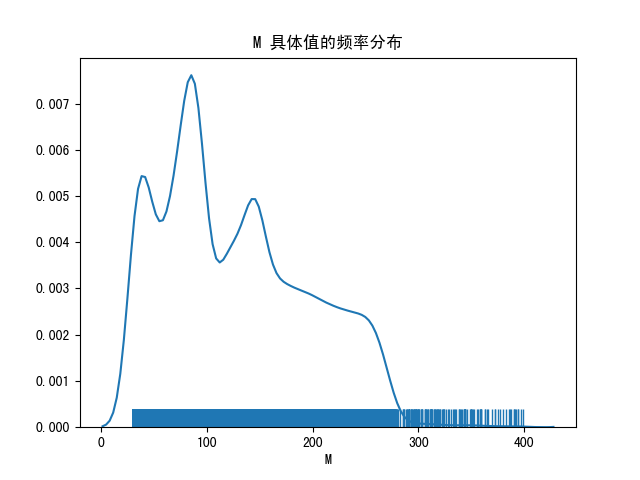

Text(0.5, 1.0, 'M 具体值的频率分布')

In [134]:
data_m=rmf[rmf['M']<400]
sns.distplot(data_m['M'],hist=False, rug=True)
pl.title('M 具体值的频率分布')

In [135]:
#步长区间验证
fanwei=list(np.arange(0,450,50))
fenzu_m=pd.cut(rmf['M'].values,fanwei,right=False)
fenzu_m

[[0, 50), [150, 200), [0, 50), [0, 50), [150, 200), ..., [150, 200), [50, 100), [200, 250), [100, 150), [150, 200)]
Length: 25420
Categories (8, interval[int64]): [[0, 50) < [50, 100) < [100, 150) < [150, 200) < [200, 250) < [250, 300) < [300, 350) < [350, 400)]

<IPython.core.display.Javascript object>


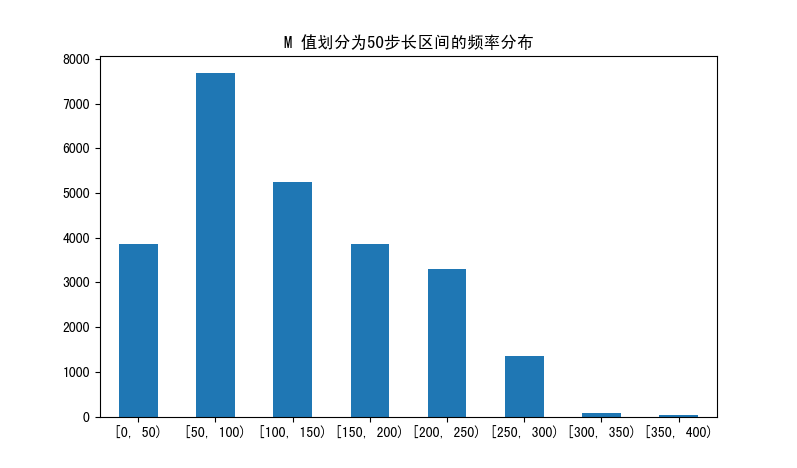

Text(0.5, 1.0, 'M 值划分为50步长区间的频率分布')

In [137]:
pinshu=fenzu_m.value_counts()
pinshu
pinshu.plot(kind='bar')
pl.xticks(rotation=0)
pl.title('M 值划分为50步长区间的频率分布')

通过上图验证可以发现将M值区间设为50，更容易根据客单价的分布判断是否符合目前客户价值结构，也更有利于发现业务中待提高的点，比如根据分布，客单价在 [200，250）这一档位的用户数与[250,300)这一档位用户相差较大，可以做专项分析查找是否还有提高[200，250）这一档位客单价的销售方案。

# 4.分值计算

In [138]:
rmf['score_R']=pd.cut(rmf['R'],bins=[0,30,60,90,120,1000000000],labels=[5,4,3,2,1],right=False).astype(float)
rmf['score_F']=pd.cut(rmf['F'],bins=[1,2,3,4,5,10000000000],labels=[1,2,3,4,5],right=False).astype(float)
rmf['score_M']=pd.cut(rmf['M'],bins=[0,50,100,150,200,1000000000],labels=[1,2,3,4,5],right=False).astype(float)

rmf.head()

,买家昵称,实付金额,F,M,R,score_R,score_F,score_M
0,.blue_ram,49,1,49.0,146,1.0,1.0,1.0
1,.christiny,183,1,183.0,152,1.0,1.0,4.0
2,.willn1,34,1,34.0,170,1.0,1.0,1.0
3,.托托m,37,1,37.0,170,1.0,1.0,1.0
4,0000妮,164,1,164.0,2,5.0,1.0,4.0


In [147]:
rmf['F是否大于均值']=(rmf['score_F']>rmf['score_F'].mean()).astype(int)
rmf['M是否大于均值']=(rmf['score_M']>rmf['score_M'].mean()).astype(int)
rmf['R是否大于均值']=(rmf['score_R']>rmf['score_R'].mean()).astype(int)
rmf.head()

# 5.客户分层

RFM经典的分层会按照R/F/M每一项指标是否高于平均值，把用户划分为8类，我们总结了一下，具体像下面表格这样：

| F是否大于均值  | M是否大于均值  | R是否大于均值  |  传统分类 |  改进分类 |  诠释 |
| :------------: | :------------: | :------------: | :------------: | :------------: | :------------: |
| 1  |  1 |   1|  重要价值客户 | 重要价值客户  | 最近购买，高频，高消费  |
|  1 | 1  | 0  |  重要换回客户 |  重要价值流失预警客户 |  最近未购，高频，高消费 |
|  1 |  0 | 0  | 一般客户  | 一般客户  |  最近未购，高频，低消费 |
|  1 |  0 | 1  | 重要潜力客户  | 消费潜力客户  | 最近购买，高频，低消费  |
| 0  |  1 |  1 |  重要深耕客户 | 提频深耕客户  | 最近购买，低频，高消费  |
|  0 |  1 | 0  |  重要挽回客户 |  高消费找回客户 |  最近未购，低频，高消费 |
| 0  |  0 |  1 | 新客户  |  新客户 | 最近购买，低频，低消费  |
| 0  |  0 | 0  |流失客户| 流失客户  | 最近未购，低频，低消费  |

In [152]:
rmf['客户指数']=rmf['F是否大于均值']*100+rmf['M是否大于均值']*10+rmf['R是否大于均值']*1
rmf.head()

,买家昵称,实付金额,F,M,R,score_R,score_F,score_M,F是否大于均值,M是否大于均值,R是否大于均值,客户指数
0,.blue_ram,49,1,49.0,146,1.0,1.0,1.0,0,0,0,0
1,.christiny,183,1,183.0,152,1.0,1.0,4.0,0,1,0,10
2,.willn1,34,1,34.0,170,1.0,1.0,1.0,0,0,0,0
3,.托托m,37,1,37.0,170,1.0,1.0,1.0,0,0,0,0
4,0000妮,164,1,164.0,2,5.0,1.0,4.0,0,1,1,11


基于指标给客户打标签

In [154]:
#判断R/F/M是否大于均值
def transform_label(x):
    if x==111:
        label='重要价值客户'
    elif x==110:
        label='重要价值流失预警客户'
    elif x==100:
        label='一般客户'
    elif x==101:
        label='消费潜力客户'
    elif x==11:
        label='提频深耕客户'
    elif x==10:
        label='高消费找回客户'
    elif x==1:
        label='新客户'
    elif x==0:
        label='流失客户'
    return label

In [155]:
rmf['客户类型']=rmf['客户指数'].apply(transform_label)
rmf.head()

,买家昵称,实付金额,F,M,R,score_R,score_F,score_M,F是否大于均值,M是否大于均值,R是否大于均值,客户指数,客户类型
0,.blue_ram,49,1,49.0,146,1.0,1.0,1.0,0,0,0,0,流失客户
1,.christiny,183,1,183.0,152,1.0,1.0,4.0,0,1,0,10,高消费找回客户
2,.willn1,34,1,34.0,170,1.0,1.0,1.0,0,0,0,0,流失客户
3,.托托m,37,1,37.0,170,1.0,1.0,1.0,0,0,0,0,流失客户
4,0000妮,164,1,164.0,2,5.0,1.0,4.0,0,1,1,11,提频深耕客户


In [156]:
count=rmf['客户类型'].value_counts().reset_index()
count.columns=['客户类型','人数']
count['人数占比']=count['人数']/count['人数'].sum()
count

,客户类型,人数,人数占比
0,高消费找回客户,7338,0.288670
1,流失客户,6680,0.262785
2,提频深耕客户,5427,0.213493
3,新客户,4224,0.166168
4,重要价值客户,756,0.029740
5,消费潜力客户,450,0.017703
6,重要价值流失预警客户,360,0.014162
7,一般客户,185,0.007278


探究不同类型客户消费金额贡献占比：

In [157]:
rmf['消费总金额']=rmf['F']*rmf['M']
money=rmf.groupby(['客户类型'])['消费总金额'].sum().reset_index()
money['消费占比']=money['消费总金额']/money['消费总金额'].sum()
money

,客户类型,消费总金额,消费占比
0,一般客户,25803.0,0.007349
1,提频深耕客户,981893.0,0.279638
2,新客户,270869.0,0.077142
3,流失客户,444617.0,0.126624
4,消费潜力客户,64075.0,0.018248
5,重要价值客户,269230.0,0.076675
6,重要价值流失预警客户,116665.0,0.033226
7,高消费找回客户,1338153.0,0.381098


In [158]:
result=pd.merge(count,money,how='inner',on='客户类型')
result

,客户类型,人数,人数占比,消费总金额,消费占比
0,高消费找回客户,7338,0.288670,1338153.0,0.381098
1,流失客户,6680,0.262785,444617.0,0.126624
2,提频深耕客户,5427,0.213493,981893.0,0.279638
3,新客户,4224,0.166168,270869.0,0.077142
4,重要价值客户,756,0.029740,269230.0,0.076675
5,消费潜力客户,450,0.017703,64075.0,0.018248
6,重要价值流失预警客户,360,0.014162,116665.0,0.033226
7,一般客户,185,0.007278,25803.0,0.007349
